# Regularized Regression Practice

Why regularize?

- Reduce complexity
- Reduce the chance of overfitting
- Reduce model variance at the expense of introducing small bias
- Increase model interpretability

What even is L1 or L2?

### Review:

What is L1 Regularization (LASSO) good for?

- feature selection! 

What is L2 Regularization (Ridge) good for?

- reducing impact of multicollinear features


In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

![baby penguin gif from Giphy](https://media.giphy.com/media/RiJuDMqd6vDgfPrZN2/giphy.gif)

Let's hang out with penguins some more:

In [2]:
data = sns.load_dataset('penguins')

In [3]:
data.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
species              344 non-null object
island               344 non-null object
culmen_length_mm     342 non-null float64
culmen_depth_mm      342 non-null float64
flipper_length_mm    342 non-null float64
body_mass_g          342 non-null float64
sex                  333 non-null object
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


Let's clean up this dataset - two rows have quite a few null values, and 11 total do not have a value for `sex`, so let's drop rows where any data is null:

In [5]:
# Drop nulls here
data = data.dropna(how='any')

In [7]:
# Sanity check
data.isna().sum()

species              0
island               0
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333 entries, 0 to 343
Data columns (total 7 columns):
species              333 non-null object
island               333 non-null object
culmen_length_mm     333 non-null float64
culmen_depth_mm      333 non-null float64
flipper_length_mm    333 non-null float64
body_mass_g          333 non-null float64
sex                  333 non-null object
dtypes: float64(4), object(3)
memory usage: 20.8+ KB


### Encoding Our Data

In [9]:
data[['species','island','sex']].describe()

,species,island,sex
count,333,333,333
unique,3,3,2
top,Adelie,Biscoe,MALE
freq,146,163,168


In order to use the `gender`, `species` or `island` data we need to render those strings as numbers - since there are only 2-3 unique values per column, let's simply one-hot-encode those columns (aka turn the columns into a series of binary indicators).

Using Pandas' `get_dummies` : https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.get_dummies.html

In [41]:
# One hot encode our three 'object' columns
data_num = pd.get_dummies(data, columns=['species', 'island', 'sex'])
#                           drop_first=True)

In [42]:
data_num.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,species_Adelie,species_Chinstrap,species_Gentoo,island_Biscoe,island_Dream,island_Torgersen,sex_FEMALE,sex_MALE
0,39.1,18.7,181.0,3750.0,1,0,0,0,0,1,0,1
1,39.5,17.4,186.0,3800.0,1,0,0,0,0,1,1,0
2,40.3,18.0,195.0,3250.0,1,0,0,0,0,1,1,0
4,36.7,19.3,193.0,3450.0,1,0,0,0,0,1,1,0
5,39.3,20.6,190.0,3650.0,1,0,0,0,0,1,0,1


You'll note that Pandas' `get_dummies` does not automatically drop one of the columns - even though the two `sex` columns, `sex_FEMALE` and `sex_MALE`, are simply inverses of each other, and thus one of those columns contains the same amount of information as having both of those columns, it keeps both. That's fine for now.

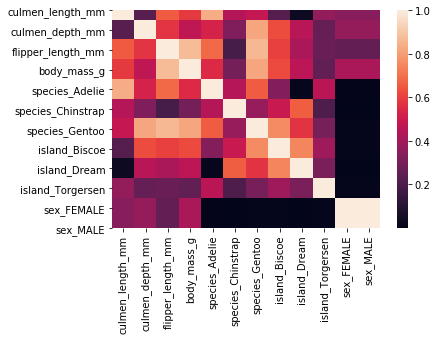

In [43]:
sns.heatmap(data_num.corr().abs())
plt.show()

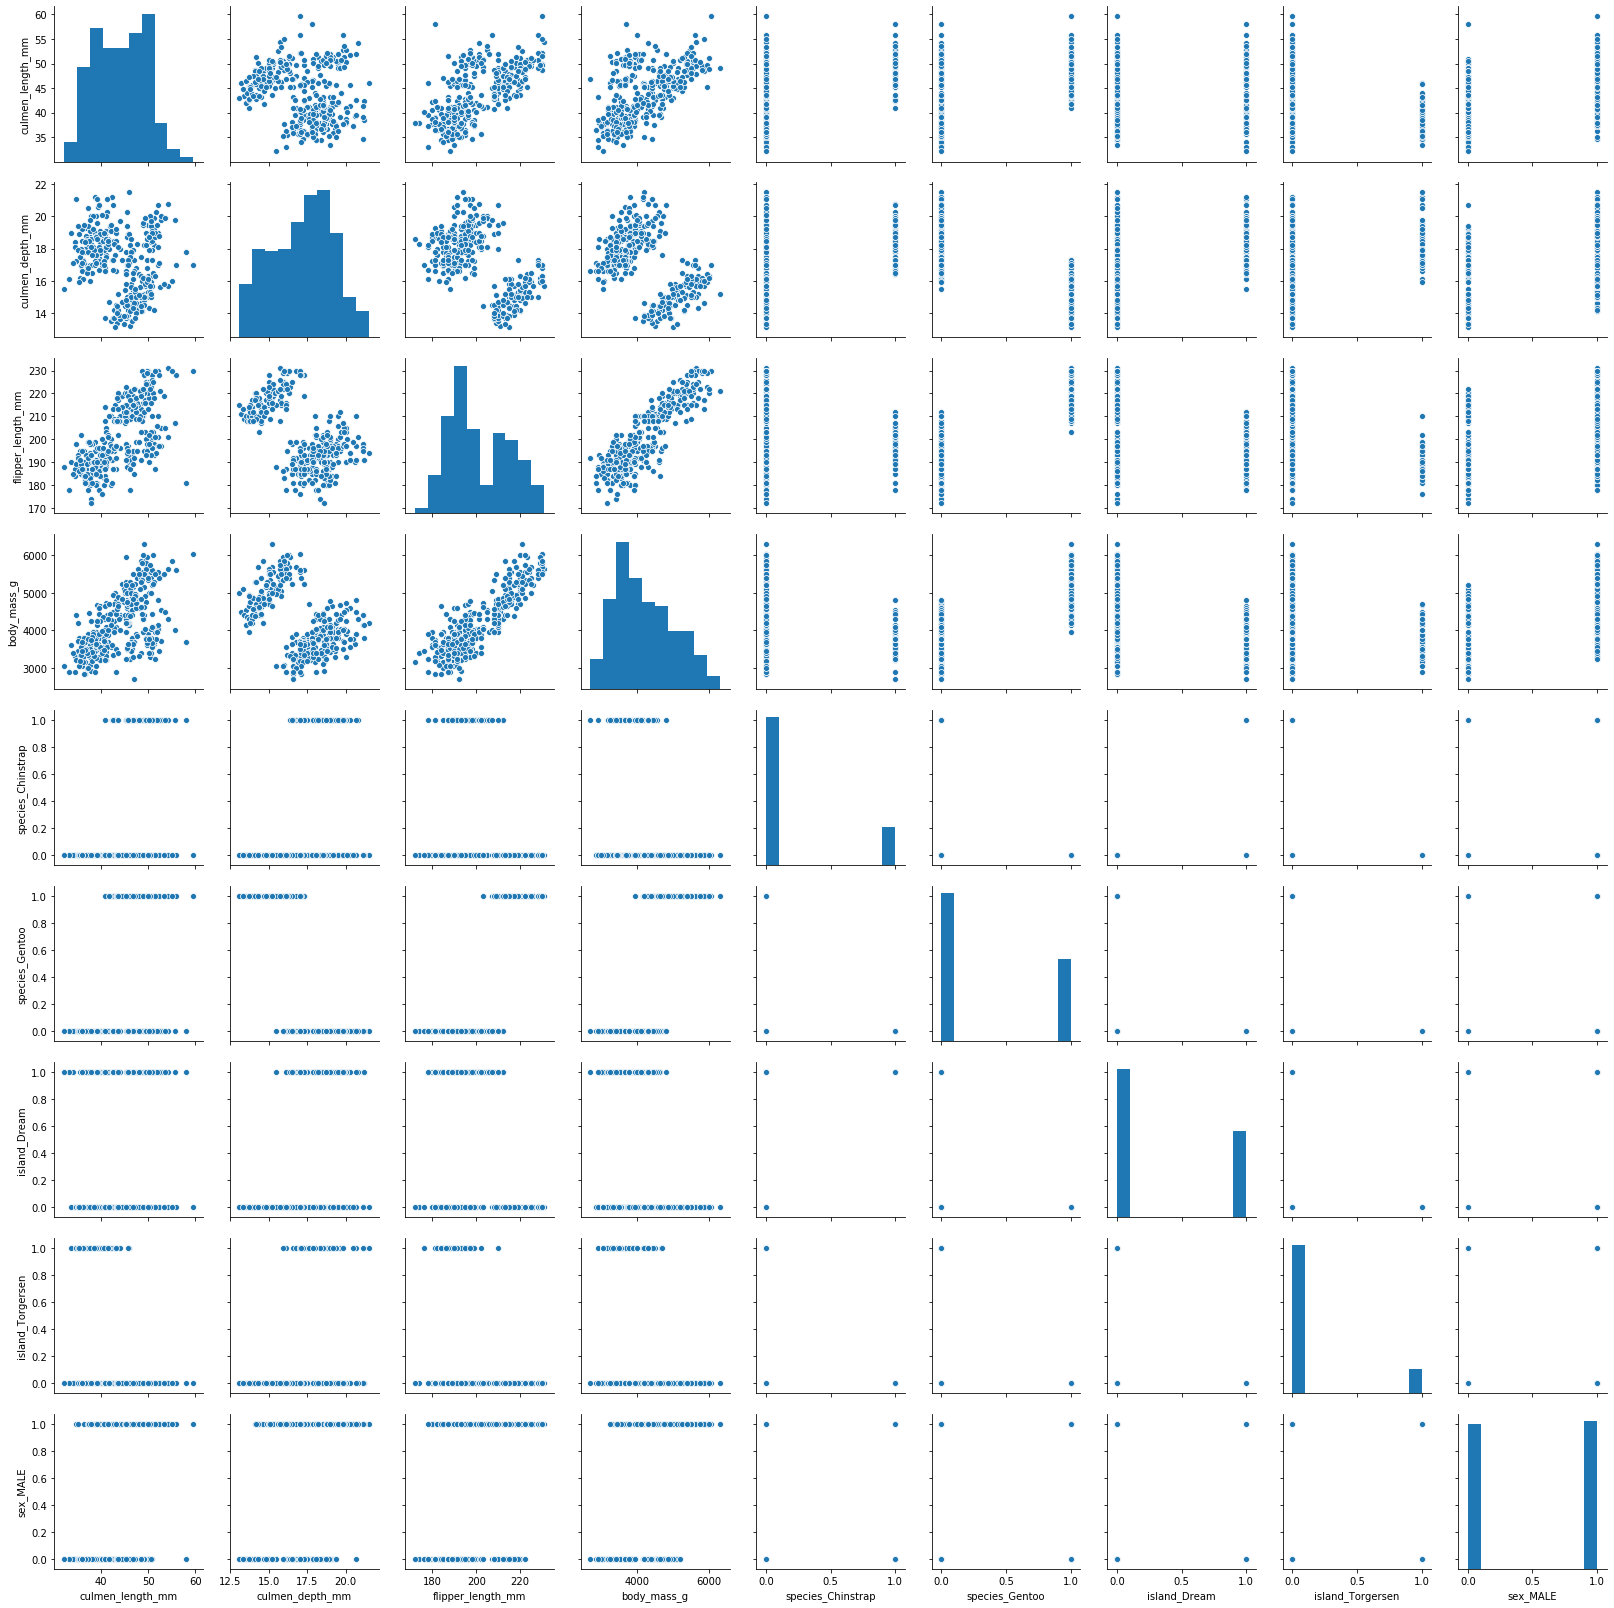

In [19]:
sns.pairplot(data_num)

The goal of this is to predict body mass, `body_mass_g`, so let's define our X and y and perform a train/test split:

In [44]:
# Define X and y
X_cols = [c for c in data_num.columns.to_list() if c not in ['body_mass_g']]

X = data_num[X_cols]
y = data_num.body_mass_g

In [45]:
# Perform a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [46]:
len(X_test) + len(X_train) == len(X)

True

In [47]:
X_train.shape

(249, 11)

In [48]:
X_test.shape

(84, 11)

### Scaling our Data:

When we introduced scaling variables last week, we talked about how some models require that we scale or standardize variables before using those models - Ridge and LASSO regression are two of those models!

Why? Because both Ridge and LASSO look at the coefficients of a linear regression model to penalize those coefficients. Coefficients of linear models are highly dependent on the values of those models - making sure they're properly scaled will make sure that our model penalizes actually useless columns, instead of just thinking those columns are useless because the data isn't properly scaled.

In [49]:
# Instantiate a scaler
scaler = StandardScaler()

In [50]:
# Train our scaler on training data, then fit to testing
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Baseline Linear Regression Model

In [51]:
# Instantiate a linear regression model
lr = LinearRegression()

In [52]:
# Fit our model on our scaled data
lr.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [53]:
# Evaluate
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

print("Training Scores:")
print(f"R2: {r2_score(y_train, y_train_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred)}")
print("---")
print("Testing Scores:")
print(f"R2: {r2_score(y_test, y_test_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred)}")

Training Scores:
R2: 0.8854734053170266
Mean Absolute Error: 221.20535292581226
---
Testing Scores:
R2: 0.8302978779660495
Mean Absolute Error: 241.08880695587536


### L1 Norm: LASSO

In [54]:
# Instantiate a lasso regression model
lasso = Lasso(alpha=.5)

In [55]:
# Fit your new L1 model -  on the scaled data
lasso.fit(X_train_scaled, y_train)

Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [56]:
# Evaluate=
y_train_pred_l1 = lasso.predict(X_train_scaled)
y_test_pred_l1 = lasso.predict(X_test_scaled)

print("Training Scores:")
print(f"R2: {r2_score(y_train, y_train_pred_l1)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred_l1)}")
print("---")
print("Testing Scores:")
print(f"R2: {r2_score(y_test, y_test_pred_l1)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred_l1)}")

Training Scores:
R2: 0.8854676477284621
Mean Absolute Error: 221.28545320499603
---
Testing Scores:
R2: 0.8305790250543101
Mean Absolute Error: 240.92339885293958


Remember - what's the benefit of using LASSO?

In [57]:
data_num.columns

Index(['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm',
       'body_mass_g', 'species_Adelie', 'species_Chinstrap', 'species_Gentoo',
       'island_Biscoe', 'island_Dream', 'island_Torgersen', 'sex_FEMALE',
       'sex_MALE'],
      dtype='object')

In [58]:
print("Unpenalized Linear Regression Coefficients are:{}".format(lr.coef_))
print("Unpenalized Linear Regression Intercept:{}".format(lr.intercept_))
print("---")
print("Lasso Regression Coefficients are:{}".format(lasso.coef_))
print("Lasso Linear Regression Intercept:{}".format(lasso.intercept_))

Unpenalized Linear Regression Coefficients are:[  86.02292514  156.36221301  214.80443239 -162.79617806 -224.84751205
  361.31304185   18.96076689   -4.56809398  -20.15707542  -92.76622529
   92.76622529]
Unpenalized Linear Regression Intercept:4239.156626506024
---
Lasso Regression Coefficients are:[ 8.53512673e+01  1.52333666e+02  2.15982708e+02 -2.57499536e+01
 -1.09649204e+02  4.89858864e+02  2.41967330e+01 -0.00000000e+00
 -1.59071713e+01 -1.86601961e+02  2.20547899e-11]
Lasso Linear Regression Intercept:4239.156626506024


### L2 Norm: Ridge

In [59]:
# Instantiate a lasso regression model
ridge = Ridge(alpha=.5)

In [60]:
# Fit your new L2 model -  on the scaled data
ridge.fit(X_train_scaled, y_train)

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [61]:
# Evaluate
y_train_pred_l2 = ridge.predict(X_train_scaled)
y_test_pred_l2 = ridge.predict(X_test_scaled)

print("Training Scores:")
print(f"R2: {r2_score(y_train, y_train_pred_l2)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred_l2)}")
print("---")
print("Testing Scores:")
print(f"R2: {r2_score(y_test, y_test_pred_l2)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred_l2)}")

Training Scores:
R2: 0.8854636797731958
Mean Absolute Error: 221.28212676264056
---
Testing Scores:
R2: 0.830592716381594
Mean Absolute Error: 240.9014885857705


In [62]:
print("Unpenalized Linear Regression Coefficients are:{}".format(lr.coef_))
print("Unpenalized Linear Regression Intercept:{}".format(lr.intercept_))
print("---")
print("Ridge Regression Coefficients are:{}".format(ridge.coef_))
print("Ridge Linear Regression Intercept:{}".format(ridge.intercept_))

Unpenalized Linear Regression Coefficients are:[  86.02292514  156.36221301  214.80443239 -162.79617806 -224.84751205
  361.31304185   18.96076689   -4.56809398  -20.15707542  -92.76622529
   92.76622529]
Unpenalized Linear Regression Intercept:4239.156626506024
---
Ridge Regression Coefficients are:[  86.8807923   151.19531226  217.17685792 -159.43140588 -222.09985798
  355.47873737   20.14995639   -5.68216754  -20.3057137   -93.29886154
   93.29886154]
Ridge Linear Regression Intercept:4239.156626506024


All together:

In [63]:
coef_dict = {}
for loc, col in enumerate(data_num.columns):
    coef_dict[col] = {"Unpenalized": lr.coef_[loc-1],
                      "LASSO": lasso.coef_[loc-1],
                      "Ridge": ridge.coef_[loc-1]}
pd.DataFrame.from_dict(coef_dict)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,species_Adelie,species_Chinstrap,species_Gentoo,island_Biscoe,island_Dream,island_Torgersen,sex_FEMALE,sex_MALE
Unpenalized,9.276623e+01,86.022925,156.362213,214.804432,-162.796178,-224.847512,361.313042,18.960767,-4.568094,-20.157075,-92.766225,9.276623e+01
LASSO,2.205479e-11,85.351267,152.333666,215.982708,-25.749954,-109.649204,489.858864,24.196733,-0.000000,-15.907171,-186.601961,2.205479e-11
Ridge,9.329886e+01,86.880792,151.195312,217.176858,-159.431406,-222.099858,355.478737,20.149956,-5.682168,-20.305714,-93.298862,9.329886e+01


### Alpha Levels??

We started with the **hyperparameter** alpha set to `0.5` for both our LASSO and Ridge Models: now let's play around with it!

In [64]:
alphas = [.25, .5, 1, 10, 50, 100]

In [68]:
for a in alphas:
    lasso_testing = Lasso(alpha = a)
    lasso_testing.fit(X_train_scaled, y_train)
    y_train_pred_testing = lasso_testing.predict(X_train_scaled)
    y_test_pred_testing = lasso_testing.predict(X_test_scaled)

    print(f"Training Scores at alpha: {a}")
    print(f"R2: {r2_score(y_train, y_train_pred_testing)}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred_testing)}")
    print("---")
    print(f"Testing Scores at alpha: {a}")
    print(f"R2: {r2_score(y_test, y_test_pred_testing)}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred_testing)}")
    print("---")
    print(f"Coefficients at alpha: {a} are: {lasso_testing.coef_}")
    print(f"Intercept at alpha: {a} is:{lasso_testing.intercept_}")
    print("*" * 20)

Training Scores at alpha: 0.25
R2: 0.8854719659198854
Mean Absolute Error: 221.24540306540422
---
Testing Scores at alpha: 0.25
R2: 0.830439797628614
Mean Absolute Error: 241.00573063072187
---
Coefficients at alpha: 0.25 are: [ 8.56870962e+01  1.54347939e+02  2.15393570e+02 -1.88547326e+02
 -2.45823716e+02  3.34210997e+02  2.39303050e+01 -0.00000000e+00
 -1.63377532e+01 -1.86067206e+02  2.40084686e-11]
Intercept at alpha: 0.25 is:4239.156626506024
********************
Training Scores at alpha: 0.5
R2: 0.8854676477284621
Mean Absolute Error: 221.28545320499603
---
Testing Scores at alpha: 0.5
R2: 0.8305790250543101
Mean Absolute Error: 240.92339885293958
---
Coefficients at alpha: 0.5 are: [ 8.53512673e+01  1.52333666e+02  2.15982708e+02 -2.57499536e+01
 -1.09649204e+02  4.89858864e+02  2.41967330e+01 -0.00000000e+00
 -1.59071713e+01 -1.86601961e+02  2.20547899e-11]
Intercept at alpha: 0.5 is:4239.156626506024
********************
Training Scores at alpha: 1
R2: 0.8854484790212975
Mean

In [69]:
for a in alphas:
    ridge_testing = Ridge(alpha = a)
    ridge_testing.fit(X_train_scaled, y_train)
    y_train_pred_testing = ridge_testing.predict(X_train_scaled)
    y_test_pred_testing = ridge_testing.predict(X_test_scaled)

    print(f"Training Scores at alpha: {a}")
    print(f"R2: {r2_score(y_train, y_train_pred_testing)}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred_testing)}")
    print("---")
    print(f"Testing Scores at alpha: {a}")
    print(f"R2: {r2_score(y_test, y_test_pred_testing)}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred_testing)}")
    print("---")
    print(f"Coefficients at alpha: {a} are: {ridge_testing.coef_}")
    print(f"Intercept at alpha: {a} is:{ridge_testing.intercept_}")
    print("*" * 20)

Training Scores at alpha: 0.25
R2: 0.8854709082990775
Mean Absolute Error: 221.24463336862152
---
Testing Scores at alpha: 0.25
R2: 0.8304509831311626
Mean Absolute Error: 240.98343040554832
---
Coefficients at alpha: 0.25 are: [  86.45858436  153.74392442  216.020848   -161.08528863 -223.45567571
  358.35099527   19.56209524   -5.13093937  -20.23290974  -93.03503192
   93.03503192]
Intercept at alpha: 0.25 is:4239.156626506024
********************
Training Scores at alpha: 0.5
R2: 0.8854636797731958
Mean Absolute Error: 221.28212676264056
---
Testing Scores at alpha: 0.5
R2: 0.830592716381594
Mean Absolute Error: 240.9014885857705
---
Coefficients at alpha: 0.5 are: [  86.8807923   151.19531226  217.17685792 -159.43140588 -222.09985798
  355.47873737   20.14995639   -5.68216754  -20.3057137   -93.29886154
   93.29886154]
Intercept at alpha: 0.5 is:4239.156626506024
********************
Training Scores at alpha: 1
R2: 0.8854364672040784
Mean Absolute Error: 221.3521110046913
---
Testin

### Resources

- [Stats course resource from Penn State](https://online.stat.psu.edu/stat508/lesson/5), going into detail about Regression Shrinkage Methods - aka regularization. This is pretty technical, and the code is in R, but goes into good detail about the motivation of why we do this and how this works.